In [1]:
import os
import numpy as np
import pandas as pd
import joblib
import json
import tensorflow as tf
import gc
import matplotlib.pyplot as plt
import sys
from tqdm.notebook import tqdm

In [2]:
tuning_path = '/home/pedro.lima/workspace/CERN-ATLAS-Qualify-1/analysis/tunings/TrigL2_20180125_v8'
tuning_file = "ElectronRingerMediumTriggerConfig.json"
with open(os.path.join(tuning_path,tuning_file)) as f:
    conf = json.load(f)

In [3]:
#conf

In [4]:
def open_zee(path= ""):
    '''
    This function will get a .npz file and transform into a pandas DataFrame. 
    The .npz has three types of data: float, int and bool this function will concatenate these features and reorder them.

    Arguments:
    path (str) - the full path to .npz file
    '''
    # open the file
    d = dict(np.load(path, allow_pickle=True))
    print(d.keys())
    df = pd.DataFrame(d['data'],columns=d["features"])
    
    df['target'] = d['target']
    df['et_bin'] = d['etBinIdx']
    df['eta_bin'] = d['etaBinIdx']
    return df

In [5]:
et = 4
eta = 0
# my pc path
#data_path = '/media/natmourajr/Backup/Work/CERN/Qualify/cern_data/Zee_boosted/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins_et0_eta0.npz'
# LPS path
data_path = '/home/pedro.lima/data/data17_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM1.bkg.VProbes_EGAM7.GRL_v97/data17_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM1.bkg.VProbes_EGAM7.GRL_v97_et%i_eta%i.npz' %(et, eta)
df = open_zee(data_path)

dict_keys(['features', 'etBins', 'etaBins', 'etBinIdx', 'etaBinIdx', 'data', 'target'])


In [6]:
df.head()

,avgmu,L2Calo_ring_0,L2Calo_ring_1,L2Calo_ring_2,L2Calo_ring_3,L2Calo_ring_4,L2Calo_ring_5,L2Calo_ring_6,L2Calo_ring_7,L2Calo_ring_8,...,el_lhmedium,el_lhloose,el_lhvloose,T0HLTElectronT2CaloTight,T0HLTElectronT2CaloMedium,T0HLTElectronT2CaloLoose,T0HLTElectronT2CaloVLoose,target,et_bin,eta_bin
0,31.459999,946.455200,297.285675,-162.731384,238.094727,-204.648712,112.230659,29.744968,43.871647,4150.571289,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0
1,31.420000,1155.483643,231.537582,841.838196,-32.028019,317.318054,412.808563,19.779219,-101.355553,12582.793945,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0
2,31.459999,2306.196045,123.935341,-92.987045,-264.076416,172.244553,-83.377022,109.801102,-15.553493,8039.985840,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0
3,31.459999,1661.695190,311.053619,-193.597885,-127.421242,386.362854,156.423721,182.063248,-88.269615,6214.927246,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0
4,31.459999,716.282349,572.603027,24.837866,-122.357193,-38.153748,-149.753250,205.552399,-74.376228,4822.833984,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0


In [20]:
def add_tuning_decision_zee(df, tuning_path, config_dict):
        #find et and eta bin
        idx = (df['et_bin']+df['eta_bin']).unique()[0]
        #print(idx)

        m_path = tuning_path
        m_model_path = os.path.join(m_path,config_dict["Model__path"][idx].replace('.onnx',''))
        with open(m_model_path + '.json', 'r') as f:
                sequential = json.load(f) 
        model = tf.keras.models.model_from_json(json.dumps(sequential, separators=(',', ':')))
        model.load_weights(m_model_path + '.h5')
        slope, offset = config_dict["Threshold__slope"][idx],config_dict["Threshold__offset"][idx]

        # ring list
        rings = ['L2Calo_ring_%i' %(iring) for iring in range(100)] 

        def norm1( data ): 
                norms = np.abs( data.sum(axis=1) )
                norms[norms==0] = 1
                return data/norms[:,None] 
        df['nn_output_%s_%s'%(config_dict['__operation__'].lower(),config_dict['__version__'])] = model.predict(norm1(df[rings].values)) 
        df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = df['avgmu']*slope + offset
        df['nn_decision_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = 0
        df.loc[df['nn_output_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] > df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])],'nn_decision_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = 1 

def add_tuning_decision_removing_a_ring(df, tuning_path, config_dict, ring_id=None):
        
        if ring_id<0 or ring_id>99:
                return -1
            
        #find et and eta bin
        idx = (df['et_bin']+df['eta_bin']).unique()[0]
        #print(idx)

        m_path = tuning_path
        m_model_path = os.path.join(m_path,config_dict["Model__path"][idx].replace('.onnx',''))
        with open(m_model_path + '.json', 'r') as f:
                sequential = json.load(f) 
        model = tf.keras.models.model_from_json(json.dumps(sequential, separators=(',', ':')))
        model.load_weights(m_model_path + '.h5')
        slope, offset = config_dict["Threshold__slope"][idx],config_dict["Threshold__offset"][idx]

        # ring list
        rings = ['L2Calo_ring_%i' %(iring) for iring in range(100)]
        #                                                          |
        #                                                alterado no v8.1/2

        # replace a ring value by its mean
        df['L2Calo_ring_%i' %(ring_id)] = df['L2Calo_ring_%i' %(ring_id)].mean()

        def norm1( data ): 
                norms = np.abs( data.sum(axis=1) )
                norms[norms==0] = 1
                return data/norms[:,None] 
        df['nn_output_%s_%s_removing_%i'%(config_dict['__operation__'].lower(),config_dict['__version__'], ring_id)] = model.predict(norm1(df[rings].values)) 
        df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = df['avgmu']*slope + offset
        df['nn_decision_%s_%s_removing_%i' %(config_dict['__operation__'].lower(),config_dict['__version__'], ring_id)] = 0
        df.loc[df['nn_output_%s_%s_removing_%i' %(config_dict['__operation__'].lower(),config_dict['__version__'], ring_id)] > df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])],'nn_decision_%s_%s_removing_%i' %(config_dict['__operation__'].lower(),config_dict['__version__'], ring_id)] = 1 


In [8]:
# ring list
rings = ['L2Calo_ring_%i' %(iring) for iring in range(100)] 

def norm1( data ): 
                norms = np.abs( data.sum(axis=1) )
                norms[norms==0] = 1
                return data/norms[:,None] 
norm1(df[rings]).values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys


array([[ 1.9066030e-02,  5.9887227e-03, -3.2781705e-03, ...,
         9.5888981e-06,  9.3012309e-04, -1.2849123e-03],
       [ 9.5097004e-03,  1.9055683e-03,  6.9283792e-03, ...,
         5.7096506e-05,  1.5111542e-03,  2.3599887e-04],
       [ 4.3169573e-02,  2.3199397e-03, -1.7406201e-03, ...,
         7.7918265e-04,  7.6186750e-04,  6.2334619e-04],
       ...,
       [ 1.3338522e-02,  9.1572236e-03,  4.3471903e-03, ...,
         9.3081193e-03, -7.7347824e-05,  3.9268893e-05],
       [ 4.3570022e-03,  1.0661377e-02,  6.5613580e-03, ...,
         3.5762454e-03,  4.0346073e-04,  2.1633768e-04],
       [ 2.7849372e-02,  4.1435979e-02,  7.9749068e-03, ...,
         2.6624401e-03,  1.1911067e-03,  2.4349712e-05]], dtype=float32)

In [9]:
#tuning_path = '../tunings/TrigL2_20180125_v8'
add_tuning_decision_zee(df=df, tuning_path=tuning_path, config_dict=conf)

In [10]:
df.columns[1:101]

Index(['L2Calo_ring_0', 'L2Calo_ring_1', 'L2Calo_ring_2', 'L2Calo_ring_3',
       'L2Calo_ring_4', 'L2Calo_ring_5', 'L2Calo_ring_6', 'L2Calo_ring_7',
       'L2Calo_ring_8', 'L2Calo_ring_9', 'L2Calo_ring_10', 'L2Calo_ring_11',
       'L2Calo_ring_12', 'L2Calo_ring_13', 'L2Calo_ring_14', 'L2Calo_ring_15',
       'L2Calo_ring_16', 'L2Calo_ring_17', 'L2Calo_ring_18', 'L2Calo_ring_19',
       'L2Calo_ring_20', 'L2Calo_ring_21', 'L2Calo_ring_22', 'L2Calo_ring_23',
       'L2Calo_ring_24', 'L2Calo_ring_25', 'L2Calo_ring_26', 'L2Calo_ring_27',
       'L2Calo_ring_28', 'L2Calo_ring_29', 'L2Calo_ring_30', 'L2Calo_ring_31',
       'L2Calo_ring_32', 'L2Calo_ring_33', 'L2Calo_ring_34', 'L2Calo_ring_35',
       'L2Calo_ring_36', 'L2Calo_ring_37', 'L2Calo_ring_38', 'L2Calo_ring_39',
       'L2Calo_ring_40', 'L2Calo_ring_41', 'L2Calo_ring_42', 'L2Calo_ring_43',
       'L2Calo_ring_44', 'L2Calo_ring_45', 'L2Calo_ring_46', 'L2Calo_ring_47',
       'L2Calo_ring_48', 'L2Calo_ring_49', 'L2Calo_ring_50', '

In [11]:
nn_decision_col = df.loc[:,'nn_decision_%s_%s' %(conf['__operation__'].lower(),conf['__version__'])]
nn_output_col = df.loc[:,'nn_output_%s_%s' %(conf['__operation__'].lower(),conf['__version__'])]
#el_lh_col = df.loc[:,'el_lh%s'%(conf['__operation__'].lower())]
decision_jet = []
decision_ee = []

for irow in range(len(nn_output_col)):
    if nn_decision_col[irow] == 1:
        decision_ee += [nn_output_col[irow]]
    else:
        decision_jet += [nn_output_col[irow]]

def calculate_eff(values, threshold, first):
    passed=0
    total = len(values)
    if first:
        for value in values:
            if value<threshold:
                passed+=1
    else:
        for value in values:
            if value>threshold:
                passed+=1
    return passed/total

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

def calculate_sp(decision_jet, decision_ee, threshold):
    eff_jet = calculate_eff(decision_jet, threshold, True)
    eff_ee = calculate_eff(decision_ee, threshold, False)
    effs = [eff_jet, eff_ee]
    arit_mean = np.mean(effs)
    geom_mean = geo_mean(effs)
    return np.sqrt(arit_mean*geom_mean)

sp_vector = []
possible_thresholds = np.linspace(-1,1,100)
progresso=0

for est_threshold in tqdm(list(possible_thresholds)):
    sp_vector += [calculate_sp(decision_jet, decision_ee, est_threshold)]

    
#parameter = eff(df, total_ee)
#print (total_ee, total_jets)
threshold = possible_thresholds[np.argmax(sp_vector)]
parameter = sp_vector[np.argmax(sp_vector)]
parameter

  0%|          | 0/100 [00:00<?, ?it/s]

Percent: [####################################################################################################] 100.00% Done...


0.9833303970864706

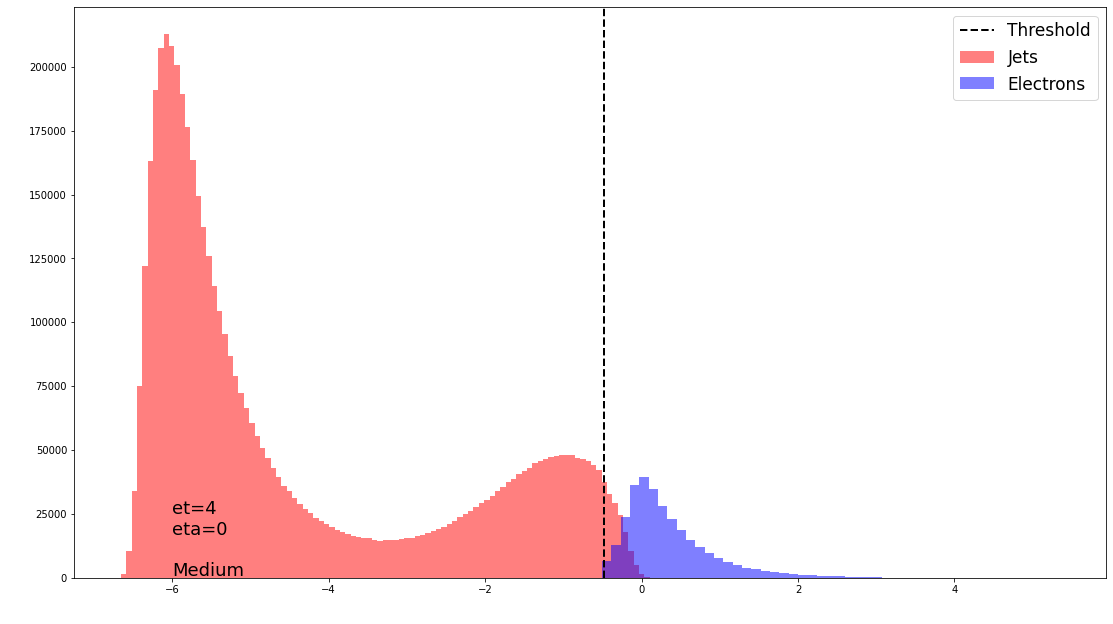

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.hist(decision_jet, bins=100, color='red', alpha=0.5, label='Jets')
plt.hist(decision_ee, bins=100, color='blue', alpha=0.5, label='Electrons')
plt.axvline(x=possible_thresholds[np.argmax(sp_vector)], color='black', ls='--', lw=2, label='Threshold')
plt.xlabel('Neural Network output', color='white', size=18)
plt.ylabel('Number of events', color='white', size=18)
plt.legend(prop={'size': 17})
plt.text(-6, 600, 'et=4\neta=0\n\n%s'%(conf['__operation__']), size=18)

plt.show()

In [ ]:
data = df.copy(deep=True)
progresso = 0
best_sps=[]
delta_sps = []

for iring in tqdm(range(100)):
    #               |
    # alterado no v8.1/2
    #sp_vector = []
    add_tuning_decision_removing_a_ring(df=data, tuning_path=tuning_path, config_dict=conf, ring_id=iring)
    data['L2Calo_ring_%i' %(iring)]=df['L2Calo_ring_%i' %(iring)]

    nn_decision_col = data.loc[:,'nn_decision_%s_%s_removing_%i'%(conf['__operation__'].lower(),conf['__version__'], iring)]
    nn_output_col = data.loc[:,'nn_output_%s_%s_removing_%i'%(conf['__operation__'].lower(),conf['__version__'], iring)]
    #el_lh_col = df.loc[:,'el_lh%s'%(conf['__operation__'].lower())]
    decision_jet = []
    decision_ee = []

    for irow in tqdm(range(len(nn_output_col)), leave=False):
        if nn_decision_col[irow] == 1:
            decision_ee += [nn_output_col[irow]]
        else:
            decision_jet += [nn_output_col[irow]]

    #possible_thresholds = np.linspace(-1,1,100)
    #for est_threshold in list(possible_thresholds):
    #    sp_local = calculate_sp(decision_jet, decision_ee, est_threshold)
    #    sp_vector += [sp_local]
    #    progresso += 1/100/100
    #    update_progress(progresso)
    #best_sps += [sp_vector[np.argmax(sp_vector)]]
    #delta_sps+=[parameter-sp_vector[np.argmax(sp_vector)]]

    sp_local = calculate_sp(decision_jet, decision_ee, threshold)
    best_sps += [sp_local]
    delta_sps += [parameter-sp_local]
    #progresso += 1/100
    #update_progress(progresso)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

  0%|          | 0/5469197 [00:00<?, ?it/s]

In [23]:
norm_sps = []
abs_delta_sps=[]
for iring in range(len(delta_sps)):
    abs_delta_sps += [np.abs(delta_sps[iring])]

max_abs_sp = abs_delta_sps[np.argmax(abs_delta_sps)]
max_sp = delta_sps[np.argmax(abs_delta_sps)]

for iring in range(len(delta_sps)):
    norm_sps += [delta_sps[iring]/max_abs_sp*100]

norm_sps

[-0.09844539298425993,
 -0.27282360692789603,
 -0.08963537482584537,
 -0.08888505883685507,
 -0.05345901611154822,
 -0.023865068160477045,
 -0.042927314420536954,
 -0.0035339650413423744,
 -0.3852245828170167,
 1.3965354077935892,
 2.588764662837051,
 100.0,
 -0.3282363686845906,
 0.8672396445694792,
 -1.5722086805914703,
 -1.228133167741029,
 -0.20914680251715756,
 -2.7669022528822165,
 -2.1034731463448835,
 -0.8040597163476902,
 -1.7292146704397289,
 -1.664769173210716,
 -1.1193012806415206,
 -1.3725721901119072,
 -0.9384955021308594,
 -0.7926478896013993,
 -0.2761774048213682,
 -0.4085581069013172,
 -0.6234807614206962,
 -0.26631054816230193,
 -0.06433940412428832,
 -0.07373605553985577,
 -0.23018227419416665,
 -0.17931390833210292,
 0.24980322895170243,
 -0.03555389029319178,
 -0.06488005287662953,
 0.34286723236809974,
 -0.0756551186269652,
 -0.029422647832618408,
 -0.06455962830681307,
 -0.12146263494506451,
 -0.09846430050092399,
 0.17843916262390044,
 -0.15829100223951076,
 -0.

In [54]:
sps = {'best':best_sps, 'delta':delta_sps, 'norm':norm_sps}

with open("sp_lists_zee.json", "w") as fp:
    json.dump(sps,fp)

In [ ]:
with open("sp_lists_zee.json", "r") as fp:
    sps = json.load(fp)
    
best_sps=sps['best']
delta_sps=sps['delta']
norm_sps=sps['norm']

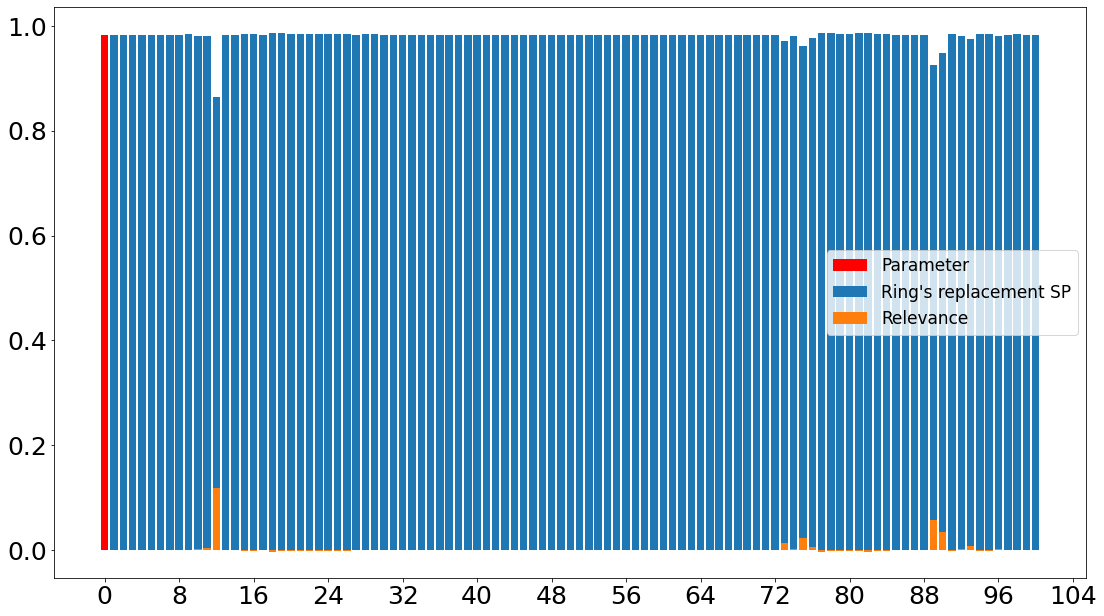

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
fig.patch.set_facecolor('white')
plt.rc('font', size=8)
plt.rc('xtick', labelsize=25, color='black')
plt.rc('ytick', labelsize=25, color='black')
ax.bar(0, parameter, color='red', label='Parameter')
ax.bar(range(1,101), best_sps, label='Ring\'s replacement SP')
#               |
#        alterado no v8.1/2
#               |
ax.bar(range(1,101), delta_sps, label='Relevance')
ax.xaxis.set_major_locator(plt.MultipleLocator(8))
ax.legend(loc='center right', prop={'size': 17})

plt.savefig('Relevance_full_data17_lhmedium_et4_eta0.png')
plt.savefig('Relevance_full_data17_lhmedium_et4_eta0.pdf')

plt.show()

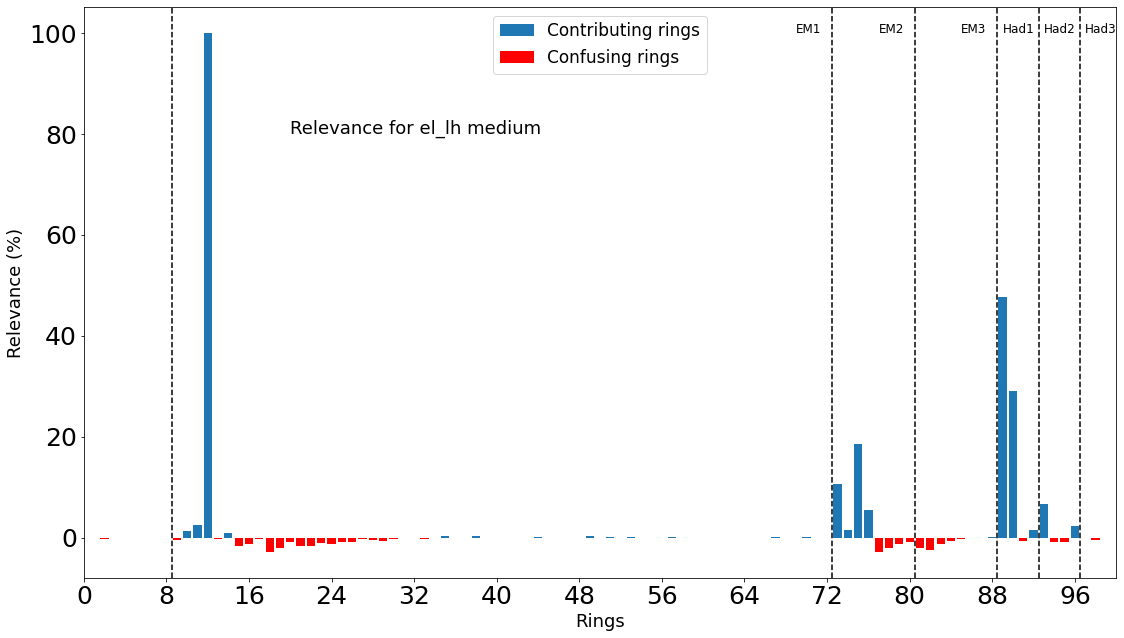

In [48]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
bars = plt.bar(range(1,101), norm_sps, label='Contributing rings')
#                       |
#               alterado no v8.1/2
plt.bar(1,0, label='Confusing rings', color='red')
plt.legend(prop={'size': 17})
ax.xaxis.set_major_locator(plt.MultipleLocator(8))
for bar in range(100):
#                 |
#        alterado no v8.1/2
    if delta_sps[bar]<0:
        bars[bar].set_fc('red')

xcoords = [8+.5,8+64+.5, 8+64+8+.5, 8+64+8+8+.5, 8+64+8+8+4+.5, 8+64+8+8+4+4+.5, 100+.5]
colors = ['black' for i in range(len(xcoords))]

for xc,c in zip(xcoords, colors):
    plt.axvline(x=xc, c=c, ls='--')

if max_sp > 0:
    where = 100
else:
    where = -100

fig.patch.set_facecolor('white')
plt.text(69, where, 'EM1', size=12)
plt.text(77, where, 'EM2', size=12)
plt.text(85, where, 'EM3', size=12)
plt.text(89, where, 'Had1', size=12)
plt.text(93, where, 'Had2', size=12)
plt.text(97, where, 'Had3', size=12)
plt.xlabel('Rings', color='black', size=18)
plt.ylabel('Relevance (%)', color='black', size=18)

plt.text(20, 80, 'Relevance for el_lh %s' %(conf['__operation__'].lower()), size = 18)

plt.xlim(left=0, right=100)

plt.savefig('Relevance_data17_lhmedium_et4_eta0.png')
plt.savefig('Relevance_data17_lhmedium_et4_eta0.pdf')

plt.show()

In [49]:
print('End of script')

End of script
